In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.integrate import trapezoid

# Parametros
L = 35  # Tamaño del dominio (en unidades adimensionales)
N = 10000 # Numero de puntos espaciales
dx = L / N  # Paso espacial
xi = np.linspace(-L / 2, L / 2, N)  # Grid espacial en unidades adimensionales
dt = 0.001  # Paso temporal (en unidades adimensionales)
t_max = 4 # Tiempo final (tiempo maximo tuneleo)
t_steps = int(t_max / dt)  # Numero de pasos temporales



# Parámetros del paquete de ondas, función de onda input
xi0 = -2.5 # Posición inicial partícula
kappa_0 = 4.5 # Momento Inicial
psi0 = (2 / np.pi)**(1/4) * np.exp(-(xi - xi0)**2) * np.exp(1j * kappa_0 * xi)



# Barrera de potencial
alpha_param = 60
v_0 = 1.25 # Altura del potencial (V_0/Ec)
b = 0.5 # Grosor de la barrera (en unidades adimensionales, realmente es xi_b)
v = v_0 / (1 + np.abs(xi / b)**alpha_param)  # Forma explicita del potencial

# Intervalo de medición de momentos
kmax = 40
kmin = 0



In [9]:
def solve_crank_nicolson (kappa_0, dx, dt, v, psi0, t):

    t_steps = int(t / dt) 
        
    # Matrices Crank-Nicolson 
    alpha = 1j * dt / (kappa_0 * dx**2)  
    beta = 1j * dt * kappa_0 / 2  

    diagonal_a = (1 + alpha + beta * v) * np.ones(N)
    off_diagonal = -(alpha / 2) * np.ones(N - 1)
    A = diags([off_diagonal, diagonal_a, off_diagonal], [-1, 0, 1], format="csr")

    diagonal_b = (1 - alpha - beta * v) * np.ones(N)
    B = diags([-off_diagonal, diagonal_b, -off_diagonal], [-1, 0, 1], format="csr")
    
    # Inicialización de la función de onda
    psi = psi0.copy()

    # Solución del problema
    for t in range(t_steps):
        psi = spsolve(A, B @ psi)

    return psi

In [10]:
def perform_momentum_measurement(psi, xi, N, kmax, kmin):
   
    dx = xi[1] - xi[0]  

    a = kmin
    b = kmax

    # TF para encontrar psi en espacio de k
    psi_k = np.fft.fft(psi) * dx  # dx para normalizar al dicretizar la versión continua de TF
    k_values = np.fft.fftfreq(N, d=dx)*2*np.pi # grid del espacio de momentos

    # Producto por theta de heaviside
    positive_k_indices = (k_values > a) & (k_values < b)
    psi_k_positive = psi_k[positive_k_indices]
    
    # Conserva el tamaño del espacio
    psi_k_full = np.zeros(N, dtype=complex)
    psi_k_full[positive_k_indices] = psi_k_positive

    # Devuelve al espacio de xi
    psi_measured = np.fft.ifft(psi_k_full) # TF inversa

    # Normalizar (pendiente)
    normalization_factor = np.sqrt(trapezoid(np.abs(psi_measured)**2, xi))
    psi_measured /= normalization_factor

    return psi_measured

In [11]:
def calculate_positive_kappa_probability(psi, xi, kmax , kmin):
    k = np.fft.fftfreq(len(xi), d=xi[1] - xi[0]) * 2 * np.pi
    psi_k = np.fft.fft(psi) * (xi[1] - xi[0])  # Fourier transform
    
    a = kmin
    b = kmax    

    positive_k_mask = (k > a) & (k < b)
    
    prob_positive_k = np.sum(np.abs(psi_k[positive_k_mask])**2)
    
    total_prob = np.sum(np.abs(psi_k)**2)
    
    return prob_positive_k / total_prob


In [12]:
def perform_Zeno (N_measurements, psi):

    if N_measurements == 0:

        print ('No Zeno Effect')

        psi = solve_crank_nicolson (kappa_0, dx, dt, v, psi, t_max)

        p = calculate_positive_kappa_probability(psi, xi, kmax, kmin)

        print('Tunneling probability = ', round(p, 4), ' ( No Zeno )')
        
    else:
        time_step = t_max / N_measurements
        
        p = calculate_positive_kappa_probability(psi, xi, kmax, kmin)

        for measurement in range (N_measurements):

            psi = solve_crank_nicolson (kappa_0, dx, dt, v, psi, time_step) # evolve to t0 + time_step
            
            p = p*calculate_positive_kappa_probability(psi, xi, kmax, kmin) # calculate prob of kappa being between kmax and kmin

            psi = (np.sqrt(p))*perform_momentum_measurement(psi, xi, N, kmax, kmin) # normalize to p


        
        print('Tunneling probability = ', round (p, 3), ' ( Zeno, N =', N_measurements,')') 


    
    
    return psi 


No Zeno Effect
Tunneling probability =  0.2013  ( No Zeno )
Tunneling probability =  0.603  ( Zeno, N = 25 )
Tunneling probability =  0.764  ( Zeno, N = 50 )
Tunneling probability =  0.971  ( Zeno, N = 500 )


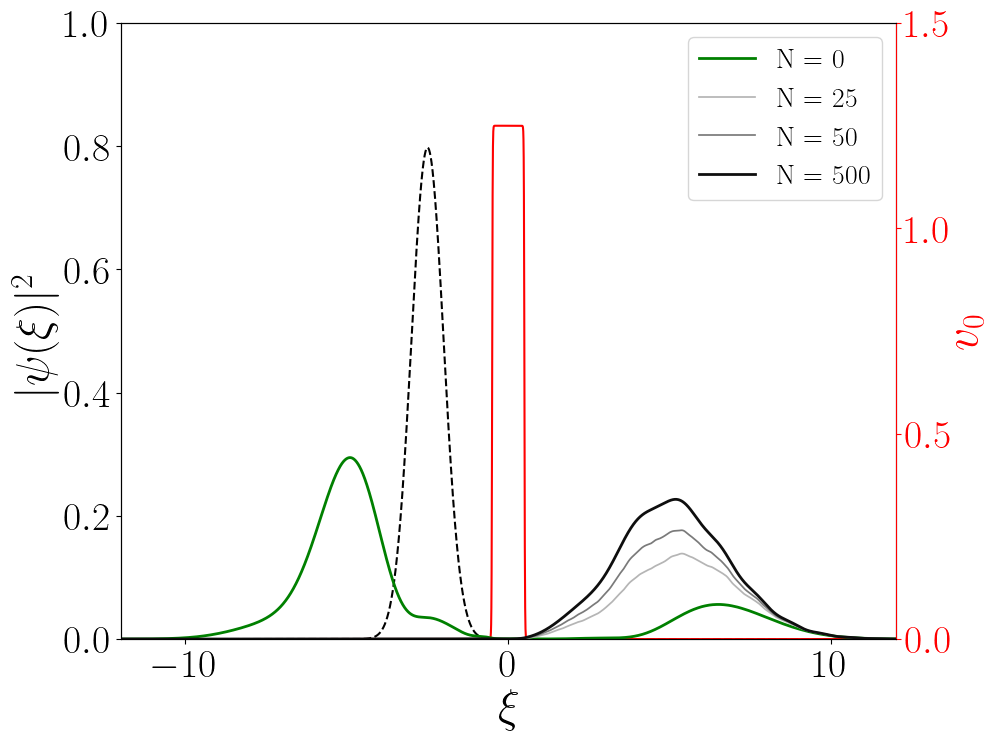

In [7]:
from matplotlib import rcParams


# Enable LaTeX rendering
rcParams['text.usetex'] = True
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern']  # Default LaTeX font


# Plot
fig, ax = plt.subplots(figsize = (10,8))

# Plot de la densidad de probabilidad
ax.set_xlim(-12, 12)
ax.set_ylim(0, 1)  
ax.set_ylabel(r'$|\psi(\xi)|^2$', size=33)

# Eje para la barrera
ax2 = ax.twinx()  
ax2.set_ylim(0, 1.5)  # Límite = max barrera pot
ax2.set_ylabel(r'$v_0$',color='r',size = 33, labelpad = -5)
ax2.tick_params(axis='y', colors='red')  
ax2.spines['right'].set_color('red') 

ax.set_xlabel(r'$\xi$', fontsize=33)

# ax2.axhline(y=1, color='black', linestyle='--',alpha = 0.33)
# plt.axvline(x=b, color='k', linestyle='--', alpha=0.33)
# plt.axvline(x=-b, color='k', linestyle='--', alpha=0.33)

line, = ax.plot(xi, np.abs(psi0)**2,color='k', linestyle ='--',linewidth=1.5) # input wavepacket

# Plot de la barrera
ax.plot(xi, v*(2/3), color='r', linestyle='-',alpha = 1, linewidth = 1.5)


# ########################################################################################################################
N_measurements = 0

psi = psi0.copy()  # Initial wavefunction

psi = perform_Zeno (N_measurements, psi)

line, = ax.plot(xi, np.abs(psi)**2,color="Green",linewidth=2, label = "N = 0") # plot de |psi|^2

# ########################################################################################################################

########################################################################################################################
N_measurements = 25
psi = psi0.copy()  # Initial wavefunction

psi = perform_Zeno (N_measurements, psi)

line, = ax.plot(xi, np.abs(psi)**2, label=f'N = {N_measurements}',color=plt.cm.Greys(0.4),linewidth=1.25) # plot de |psi|^2

########################################################################################################################

########################################################################################################################
N_measurements = 50

psi = psi0.copy()  # Initial wavefunction

psi = perform_Zeno (N_measurements, psi)

line, = ax.plot(xi, np.abs(psi)**2, label=f'N = {N_measurements}',color=plt.cm.Greys(0.6),linewidth=1.25) # plot de |psi|^2

########################################################################################################################

########################################################################################################################
N_measurements = 500

psi = psi0.copy()  # Initial wavefunction

psi = perform_Zeno (N_measurements, psi)

line, = ax.plot(xi, np.abs(psi)**2, label=f'N = {N_measurements}',color=plt.cm.Greys(0.95),linewidth=2) # plot de |psi|^2

########################################################################################################################



ax.legend(fontsize=20)

ax.tick_params(axis='both', labelsize=28.5)  # Apply to the primary axis
ax2.tick_params(axis='y', labelsize=28.5)  # Apply to the secondary axis
plt.xticks([-10, 0, 10])
ax2.set_yticks([0, 0.5, 1, 1.5])
plt.show()
